In [1]:
import numpy as np
import pandas as pd
import math
import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from warnings import simplefilter
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(12, 6),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

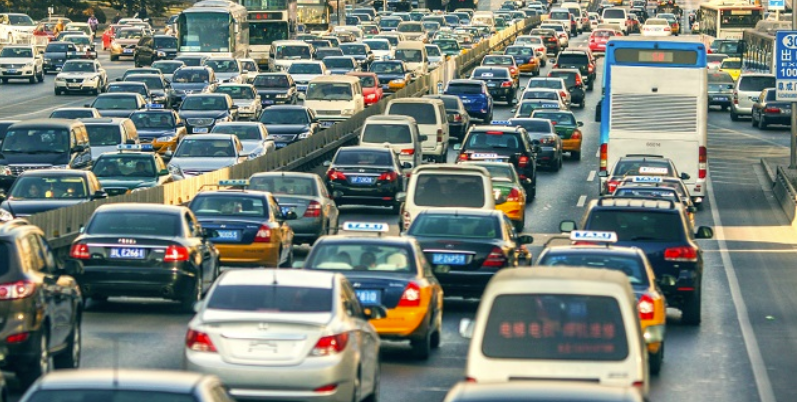

# Read the data

In [2]:
train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', index_col="row_id")
test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv', index_col="row_id")

### Train to test ratio

In [3]:
k = train.shape[0] / test.shape[0]
k

362.75

### No missing values

In [4]:
train_missing_values_count = train.isnull().sum()
test_missing_values_count  = test.isnull().sum()
train_missing_values_count, test_missing_values_count

(time          0
 x             0
 y             0
 direction     0
 congestion    0
 dtype: int64,
 time         0
 x            0
 y            0
 direction    0
 dtype: int64)

### Unique time values in train and test

In [5]:
train_time_unique_value_count = len(train['time'].unique().tolist())
test_time_unique_value_count  = len(test['time'].unique().tolist())
train_time_unique_value_count, test_time_unique_value_count, train_time_unique_value_count / test_time_unique_value_count

(13059, 36, 362.75)

# Directions
* we have eight

In [6]:
directions = train['direction'].unique().tolist()
degree = {'EB':180, 'NB':90, 'SB':270, 'WB':0, 'NE':135, 'SW':315, 'NW': 45, 'SE':225}

### Count values by direction

In [7]:
dirs = pd.DataFrame(train['direction'].value_counts())
dirs['degree'] = list(degree.values())
dirs = dirs.rename(columns={'direction':'train'})
dirs['test'] = test['direction'].value_counts()
dirs = dirs.sort_values(by='degree')
dirs['rad'] = math.pi * dirs['degree'] / 180
dirs = dirs[['degree', 'rad', 'train', 'test']]
dirs

,degree,rad,train,test
WB,0,0.000000,143649,396
NW,45,0.785398,26118,72
NB,90,1.570796,156708,432
NE,135,2.356194,91413,252
EB,180,3.141593,156708,432
SE,225,3.926991,26118,72
SB,270,4.712389,156708,432
SW,315,5.497787,91413,252


### Add directions in degrees and radians to train and test

In [8]:
tmp = dirs[['degree', 'rad']].reset_index().rename(columns={'index':'direction'})
train = pd.merge(train, tmp, on='direction', how='left')
test = pd.merge(test, tmp, on='direction', how='left')

### Plot direction distributions in train and test

Text(0.5, 1.0, 'Distributions are equal')

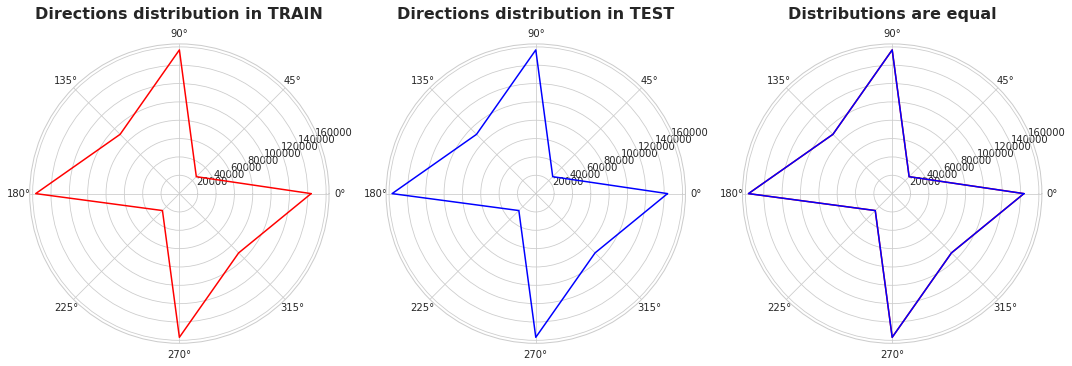

In [9]:
fig = plt.figure(figsize=(15, 5))

r1 = dirs['train'].tolist()
r2 = (dirs['test'] * k).tolist()
theta = dirs['rad'].tolist()
r1 += [r1[0]]
r2 += [r2[0]]
theta += [theta[0]]

ax = fig.add_subplot(131, projection='polar')
ax.plot(theta, r1, c='r')
ax.set_title('Directions distribution in TRAIN')

ax = fig.add_subplot(132, projection='polar')
ax.plot(theta, r2, c='b')
ax.set_title('Directions distribution in TEST')

ax = fig.add_subplot(133, projection='polar')
ax.plot(theta, r1, c='r')
ax.plot(theta, r2, c='b')
ax.set_title('Distributions are equal')


### Count values in train and test by x & y

In [10]:
coords = pd.DataFrame()
coords['train_x'] = train['x'].value_counts()
coords['train_y'] = train['y'].value_counts()
coords['test_x'] = test['x'].value_counts()
coords['test_y'] = test['y'].value_counts()
coords['test_kx'] = (test['x'].value_counts() * k).astype(int)
coords['test_ky'] = (test['y'].value_counts() * k).astype(int)

coords

,train_x,train_y,test_x,test_y,test_kx,test_ky
2,339534,235062,936,648,339534,235062
1,287298,208944,792,576,287298,208944
0,222003,169767,612,468,222003,169767


* Once again the distributions are equal

### Combain x and y into loocation feature

In [11]:
train['location'] = train['x'].astype(str) + train['y'].astype(str)
test['location']  = test['x'].astype(str) + test['y'].astype(str)

locs = pd.DataFrame()
locs['train'] = train['location'].value_counts()
locs['test'] = test['location'].value_counts()
locs['test_k'] = (test['location'].value_counts() * k).astype(int)
locs

,train,test,test_k
21,104472,288,104472
22,104472,288,104472
03,78354,216,78354
10,78354,216,78354
12,78354,216,78354
13,78354,216,78354
23,78354,216,78354
01,52236,144,52236
02,52236,144,52236
11,52236,144,52236


In [12]:
locations = locs.index.tolist() #.sort()
locations.sort()
locations

['00', '01', '02', '03', '10', '11', '12', '13', '20', '21', '22', '23']

### Plot direction distribution for each location

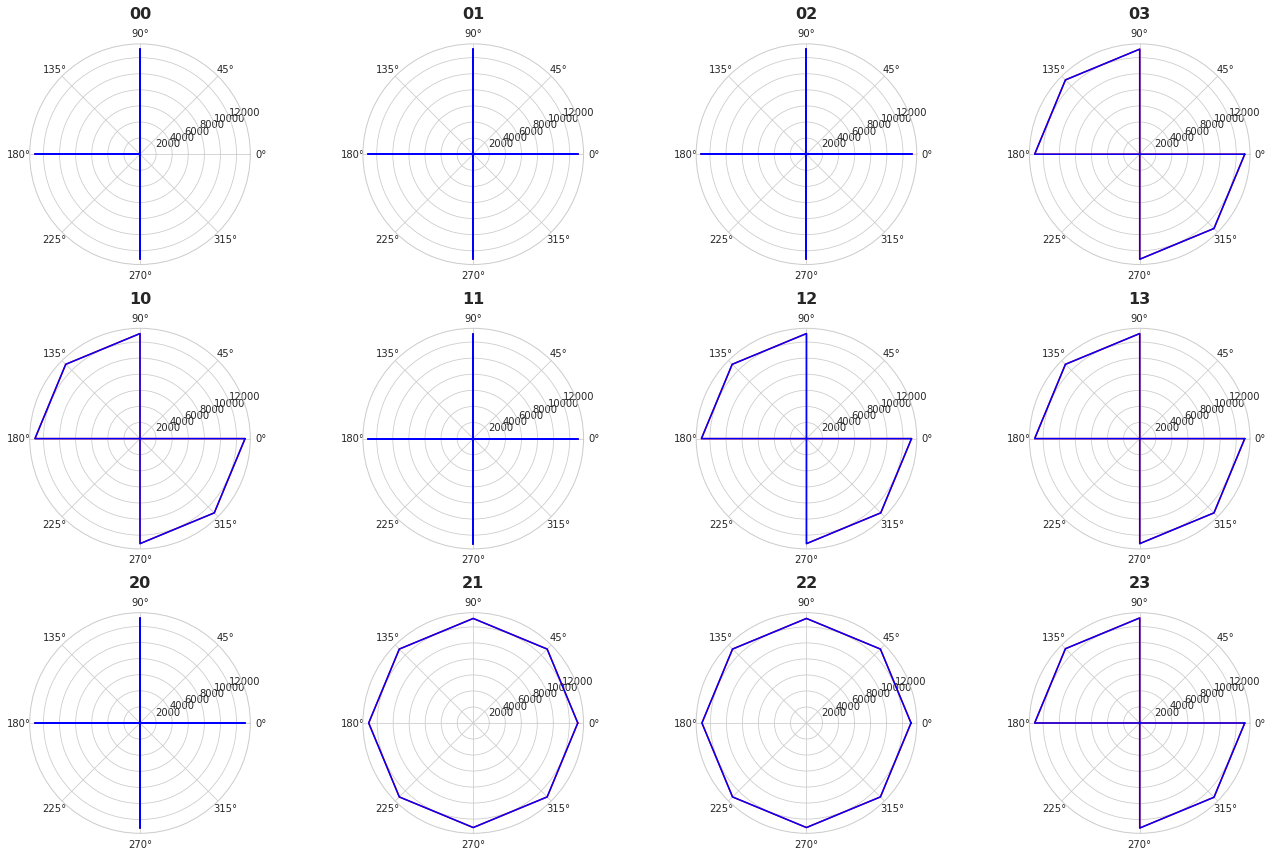

In [13]:
df = pd.DataFrame(degree.values(), index=list(degree.keys())).rename(columns={0:'degree'}).sort_values(by='degree')
df['rad'] = math.pi * df['degree'] / 180

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 12), subplot_kw=dict(projection='polar'))

for ax, lc in zip(axs.flat, locations):
    trn = train[train['location'] == lc]
    tst = test[test['location'] == lc]
    dtrn = pd.DataFrame(trn['direction'].value_counts()).rename(columns={'direction':'train'})
    dtst = pd.DataFrame(tst['direction'].value_counts()).rename(columns={'direction':'test'})
    drs = df.copy()
    drs = drs.join(dtrn).fillna(0)
    drs = drs.join(dtst).fillna(0)

    r1 = drs['train'].tolist()
    r2 = (drs['test'] * k).tolist()
    theta = drs['rad'].tolist()
    r1 += [r1[0]]
    r2 += [r2[0]]
    theta += [theta[0]]

    ax.plot(theta, r1, c='r')
    ax.plot(theta, r2, c='b')
    ax.set_title(lc)
plt.tight_layout()
plt.show()

* There is no difference between train and test in all locations. In all locations, but "00", distributions are symmetrical.

# Target

In [14]:
target = 'congestion'

### Target distribution
* It's close to normal

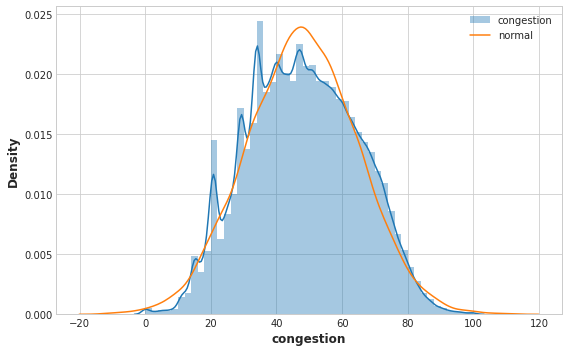

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax = sns.distplot(train[target], label=target)
m, s = train[target].mean(), train[target].std()
n = np.random.normal(loc=m, scale=s, size=(100, 100))
ax = sns.distplot(n, hist=False, label='normal')
ax.legend()

### Target distributions by location

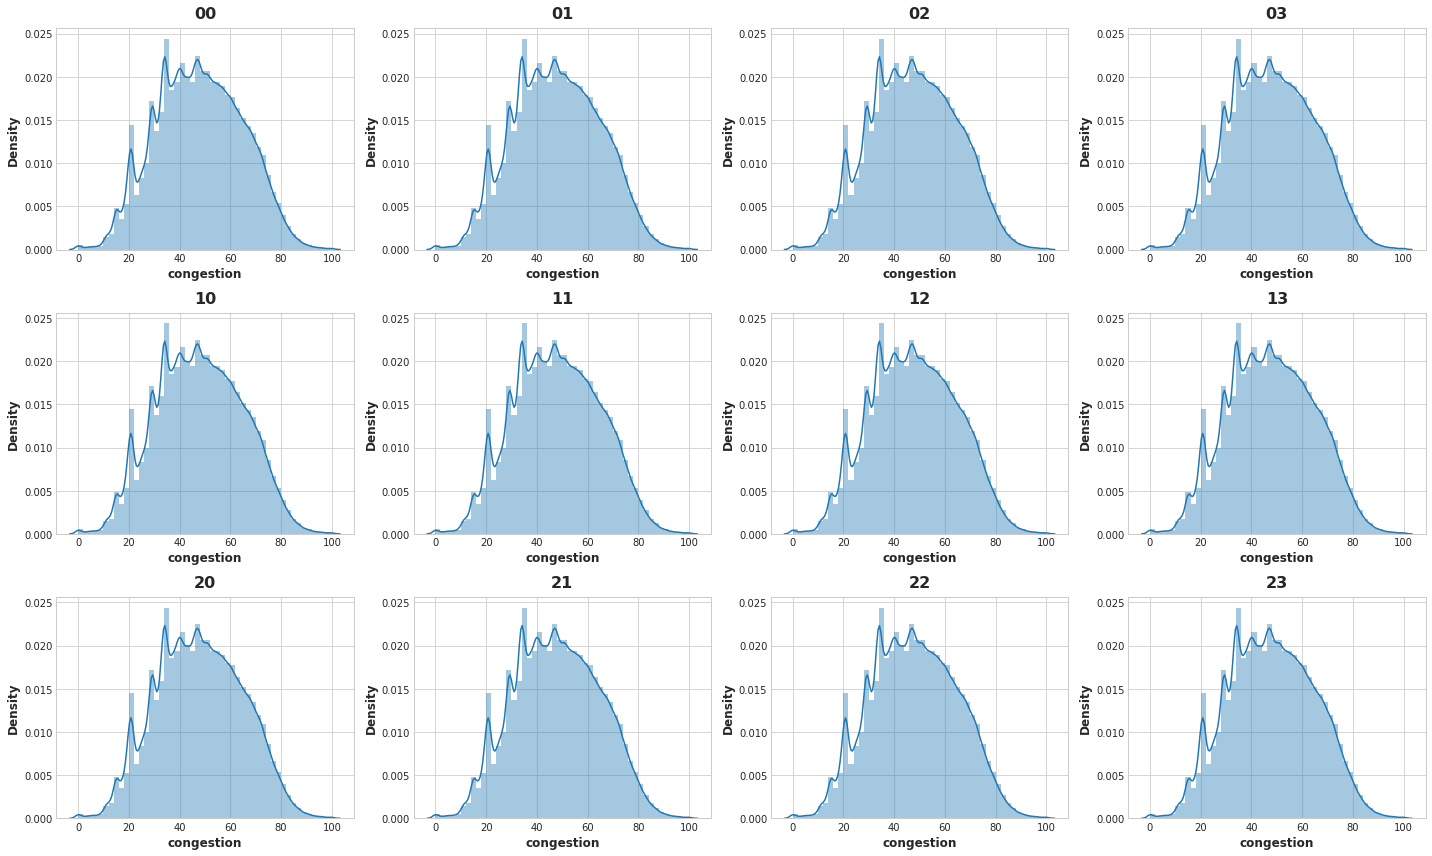

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 12))
for ax, lc in zip(axs.flat, locations):
    trn = train[train['location'] == lc]
    sns.distplot(train[target], ax=ax)
    ax.set_title(lc)
plt.tight_layout()
plt.show()    

### Target means by direction for locations
* no symmetry

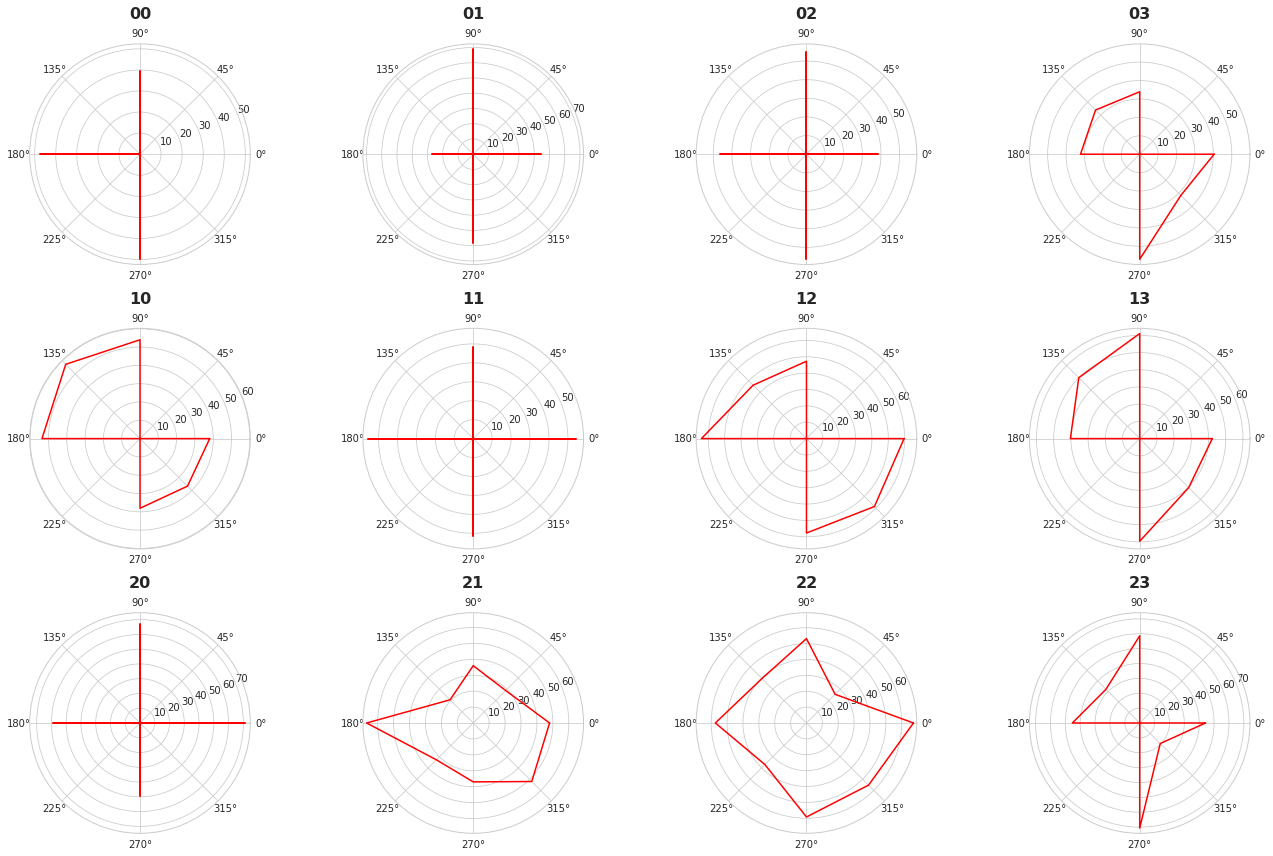

In [17]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 12), subplot_kw=dict(projection='polar'))

for ax, lc in zip(axs.flat, locations):
    trn = train[train['location'] == lc]
    dtrn = pd.DataFrame(trn.groupby(['direction']).congestion.mean())
    drs = df.copy()
    drs = drs.join(dtrn).fillna(0)

    r = drs[target].tolist()
    theta = drs['rad'].tolist()
    r += [r[0]]
    theta += [theta[0]]

    ax.plot(theta, r, c='r')
    ax.set_title(lc)
plt.tight_layout()
plt.show()

# Time

In [18]:
train['date'] = pd.to_datetime(train['time'])
train_date_min = train['date'].min()
print('train_date_min', train_date_min)
train_date_max = train['date'].max()
print('train_date_max', train_date_max)
train_date_unique = train['date'].unique()
step = train_date_unique[1] - train_date_unique[0]
print('step', step)
print('train dates count', len(list(train_date_unique)))
print('total periods between min and max date', 1 + (train_date_max - train_date_min) / step)

train_date_min 1991-04-01 00:00:00
train_date_max 1991-09-30 11:40:00
step 1200000000000 nanoseconds
train dates count 13059
total periods between min and max date 13140.0


* 81 periods are missing in train

In [19]:
test['date'] = pd.to_datetime(test['time'])
test_date_min = test['date'].min()
print('test_date_min', test_date_min)
test_date_max = test['date'].max()
print('test_date_max', test_date_max)
test_date_unique = test['date'].unique()
step = test_date_unique[1] - test_date_unique[0]
print('step', step)
print('test dates count', len(list(test_date_unique)))
print('total periods between min and max date', 1 + (test_date_max - test_date_min) / step)

test_date_min 1991-09-30 12:00:00
test_date_max 1991-09-30 23:40:00
step 1200000000000 nanoseconds
test dates count 36
total periods between min and max date 36.0


### Add date and time features

In [20]:
def add_datetime_features(df):
    df['month']   = df['date'].dt.month
    df['day']     = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday
    df['weekend'] = (df['date'].dt.weekday >= 5)
    df['hour']    = df['date'].dt.hour
    df['minute']  = df['date'].dt.minute
    
    # number of 20' period in a day
    df['moment']  = df['date'].dt.hour * 3 + df['date'].dt.minute // 20   

In [21]:
add_datetime_features(train)
add_datetime_features(test)
train

,time,x,y,direction,congestion,degree,rad,location,date,month,day,weekday,weekend,hour,minute,moment
0,1991-04-01 00:00:00,0,0,EB,70,180,3.141593,00,1991-04-01 00:00:00,4,1,0,False,0,0,0
1,1991-04-01 00:00:00,0,0,NB,49,90,1.570796,00,1991-04-01 00:00:00,4,1,0,False,0,0,0
2,1991-04-01 00:00:00,0,0,SB,24,270,4.712389,00,1991-04-01 00:00:00,4,1,0,False,0,0,0
3,1991-04-01 00:00:00,0,1,EB,18,180,3.141593,01,1991-04-01 00:00:00,4,1,0,False,0,0,0
4,1991-04-01 00:00:00,0,1,NB,60,90,1.570796,01,1991-04-01 00:00:00,4,1,0,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848830,1991-09-30 11:40:00,2,3,NB,54,90,1.570796,23,1991-09-30 11:40:00,9,30,0,False,11,40,35
848831,1991-09-30 11:40:00,2,3,NE,28,135,2.356194,23,1991-09-30 11:40:00,9,30,0,False,11,40,35
848832,1991-09-30 11:40:00,2,3,SB,68,270,4.712389,23,1991-09-30 11:40:00,9,30,0,False,11,40,35
848833,1991-09-30 11:40:00,2,3,SW,17,315,5.497787,23,1991-09-30 11:40:00,9,30,0,False,11,40,35


### Number samples with the same datetime

In [22]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
train['num'] = le.fit_transform(train['date'])
test['num'] = le.fit_transform(test['date'])

### Train target by direction for locations on the first "time"

In [23]:
one_num = train[train['num'] == 0]
for lc in locations:
    sample = one_num[one_num.location == lc]
    display(sample[['location', 'direction', target]])

,location,direction,congestion
0,00,EB,70
1,00,NB,49
2,00,SB,24


,location,direction,congestion
3,01,EB,18
4,01,NB,60
5,01,SB,58
6,01,WB,26


,location,direction,congestion
7,02,EB,31
8,02,NB,49
9,02,SB,46
10,02,WB,29


,location,direction,congestion
11,03,EB,18
12,03,NB,16
13,03,NE,21
14,03,SB,49
15,03,SW,47
16,03,WB,51


,location,direction,congestion
17,10,EB,74
18,10,NB,74
19,10,NE,43
20,10,SB,44
21,10,SW,52
22,10,WB,32


,location,direction,congestion
23,11,EB,44
24,11,NB,77
25,11,SB,39
26,11,WB,63


,location,direction,congestion
27,12,EB,53
28,12,NB,28
29,12,NE,24
30,12,SB,29
31,12,SW,54
32,12,WB,46


,location,direction,congestion
33,13,EB,41
34,13,NB,44
35,13,NE,44
36,13,SB,37
37,13,SW,15
38,13,WB,46


,location,direction,congestion
39,20,EB,44
40,20,NB,39
41,20,SB,26
42,20,WB,61


,location,direction,congestion
43,21,EB,65
44,21,NB,26
45,21,NE,16
46,21,NW,29
47,21,SB,22
48,21,SE,34
49,21,SW,45
50,21,WB,37


,location,direction,congestion
51,22,EB,42
52,22,NB,50
53,22,NE,26
54,22,NW,21
55,22,SB,36
56,22,SE,51
57,22,SW,47
58,22,WB,51


,location,direction,congestion
59,23,EB,39
60,23,NB,64
61,23,NE,30
62,23,SB,70
63,23,SW,29
64,23,WB,26


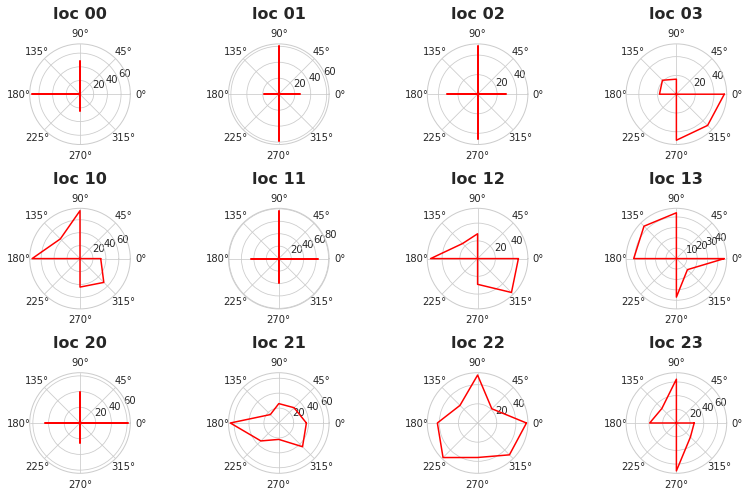

In [24]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 7), subplot_kw=dict(projection='polar'))

for ax, lc in zip(axs.flat, locations):
    sample = one_num[one_num['location'] == lc]
    dtrn = pd.DataFrame(sample.groupby(['direction']).congestion.mean())
    drs = df.copy()
    drs = drs.join(dtrn).fillna(0)

    r = drs[target].tolist()
    theta = drs['rad'].tolist()
    r += [r[0]]
    theta += [theta[0]]

    ax.plot(theta, r, c='r')
    ax.set_title(f'loc {lc}')
plt.tight_layout()
plt.show()

### Take one location point ans see how congestion changes by hour

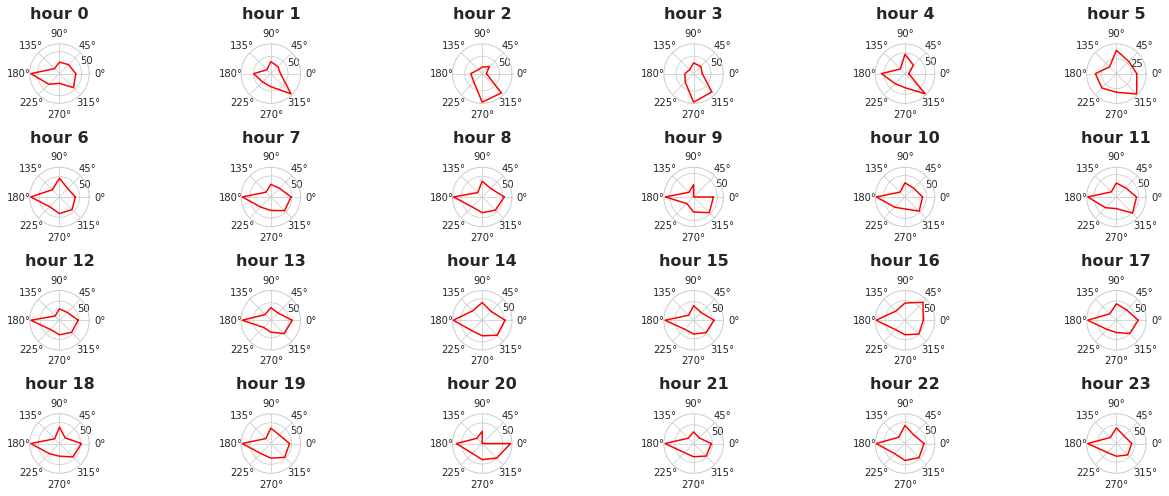

In [25]:
location = '21'
loc_train = train[train.location == location]
fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(20, 7), subplot_kw=dict(projection='polar'))

nums = [i*3 for i in range(24)]
for ax, num in zip(axs.flat, nums):
    sample = loc_train[loc_train['num'] == num]
    dtrn = pd.DataFrame(sample.groupby(['direction']).congestion.mean())
    drs = df.copy()
    drs = drs.join(dtrn).fillna(0)

    r = drs[target].tolist()
    theta = drs['rad'].tolist()
    r += [r[0]]
    theta += [theta[0]]

    ax.plot(theta, r, c='r')
    ax.set_title(f'hour {num//3}')
plt.tight_layout()
plt.show()    

### by day

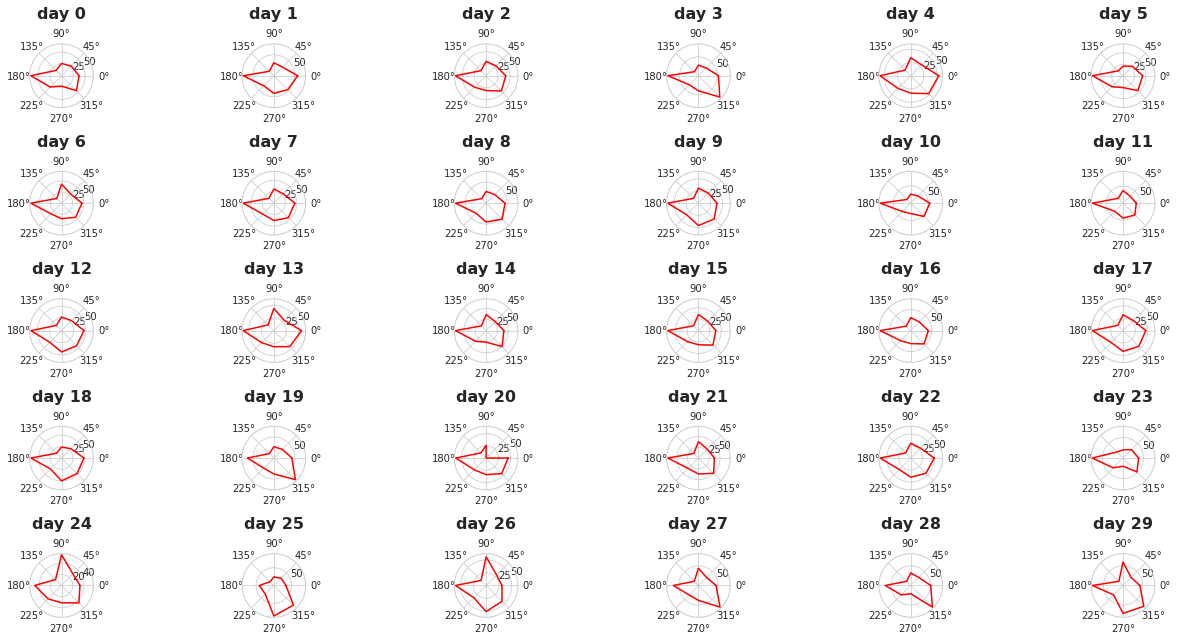

In [26]:
fig, axs = plt.subplots(nrows=5, ncols=6, figsize=(20, 9), subplot_kw=dict(projection='polar'))

nums = [i*3*24 for i in range(30)]
for ax, num in zip(axs.flat, nums):
    sample = loc_train[loc_train['num'] == num]
    dtrn = pd.DataFrame(sample.groupby(['direction']).congestion.mean())
    drs = df.copy()
    drs = drs.join(dtrn).fillna(0)

    r = drs[target].tolist()
    theta = drs['rad'].tolist()
    r += [r[0]]
    theta += [theta[0]]

    ax.plot(theta, r, c='r')
    ax.set_title(f'day {num//72}')
plt.tight_layout()
plt.show()

# Animation
* Congestion in dynamic

In [27]:
import plotly.express as px

location = '21'
loc_train = train[train.location == location]

nums = list(loc_train['num'].unique())[:50]
anime = pd.DataFrame()
for num in nums:
    sample = loc_train[loc_train['num'] == num]
    dtrn = pd.DataFrame(sample.groupby(['direction']).congestion.mean())
    drs = df.copy()
    drs = drs.join(dtrn).fillna(0)
    drs['num'] = num
    anime = pd.concat([anime, drs], axis=0)

In [28]:
px.line_polar(anime, r=target, theta="degree", line_close=True, animation_frame="num")

### If you find the notebook interesting please consider to upvote.

# To be continued ...
* The next step is model selection